[View in Colaboratory](https://colab.research.google.com/github/RayleighKim/Coursera_Advanced_Machine_Learning_Specialization/blob/master/01_Introduction_To_DeepLearning/w24_PA_my1stNN.ipynb)

# My First(?) Neural Network.

Rayleigh Kim @ D:plus

email1 : rayleigh@dplus.company  <br>
email2 : wood.rayleigh@gmail.com

--------------------------------
Actually, this is not my first time...
I'm using this Course to brush up.

---------------------------------
I modified this notebook to use
* GoogleColaboratory on Google Drive
* TensorBoard in GoogleColab Notebook (Thanks to [DeepDream notebook](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb))

## Clone (intro-to-dl) repository to GoogleColab docker

This part can be skipped in the Coursera Environment.

In [75]:
!git clone https://github.com/hse-aml/intro-to-dl.git

Cloning into 'intro-to-dl'...
remote: Counting objects: 423, done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 423 (delta 14), reused 29 (delta 8), pack-reused 377
Receiving objects: 100% (423/423), 4.36 MiB | 44.24 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [44]:
# change working directory where the original file is
cd intro-to-dl/week2

/content/intro-to-dl/week2/intro-to-dl/week2


## TensorBoard in GoogleColab notebook

In [0]:
import tensorflow as tf
import numpy as np
from IPython.display import clear_output, Image, display, HTML

"""
show_graph(tf.get_default_graph().as_graph_def())
"""


def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## Data Loading & Preprocessing

(50000, 28, 28) (50000,)


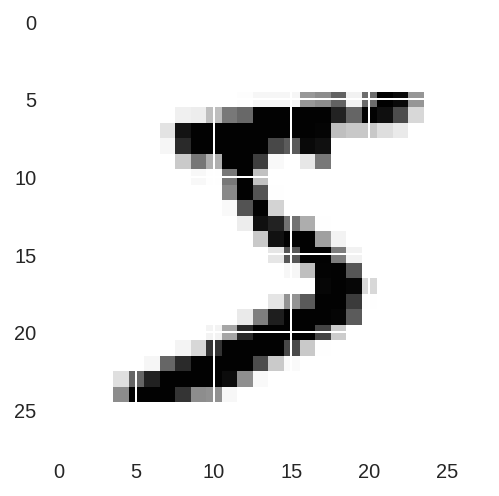

In [46]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.imshow(X_train[0], cmap="Greys");

In [47]:
print( X_train.shape, X_test.shape)

(50000, 28, 28) (10000, 28, 28)


In [48]:
print(y_train.shape, y_test.shape)

(50000,) (10000,)


In [49]:
# We just use a Simple Neural Network. Let's flatten these.
X_train, X_test = X_train.reshape([50000,-1]), X_test.reshape([10000, -1])

# We need One-hot Vector
y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]

print(X_train.shape, y_train.shape)

(50000, 784) (50000, 10)


## Neural Network!

Before starting, I'm the guy who can't code without stackoverflow. This [link](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits) and this [link2](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow) are very helpful, because I'm awlays confusing what is the logits.

1. Mathematically, Logit is a function that maps probabilities( [0, 1] ) to R ( (-inf,  inf))
2. For TensorFlow, Logit is the Tensor to being mapped to probabilities by the Softmax


In [0]:
import tensorflow as tf

In [0]:
###### Clear Any graph on Back ######
tf.reset_default_graph() ## This allows us to run this cell repeatedly


## Input Layer ##
with tf.name_scope("Input_Layer"):
    X = tf.placeholder(tf.float32, shape = [None, 28*28], name = 'X_input')

## Placeholder for Dropout ##
keep_prob = tf.placeholder(tf.float32, name = 'Drop_Out_Rate')
    
## 1st Hidden Layer ##
with tf.name_scope("Hidden_Layer_1"):
    W1 = tf.get_variable(name = 'Weight1', shape = [28*28, 384],
                         initializer = tf.contrib.layers.xavier_initializer())
    B1 = tf.Variable(tf.truncated_normal([384], mean = 0, stddev = 0.5), name = 'Bias1')
    
    Z1 = tf.add(tf.matmul(X,W1), B1, name = 'Sum1')
    A1 = tf.nn.elu(Z1, name = 'elu1')
    Ad1 = tf.nn.dropout(A1, keep_prob=keep_prob, name = 'elu1_drop')
    
## 2nd Hidden Layer ##
with tf.name_scope("Hidden_Layer_2"):
    W2 = tf.get_variable(name = 'Weight2', shape = [384, 256],
                         initializer = tf.contrib.layers.xavier_initializer())
    B2 = tf.Variable(tf.truncated_normal([256], mean = 0, stddev = 0.5), name = 'Bias2')
    
    Z2 = tf.add(tf.matmul(Ad1,W2), B2, name = 'Sum2')
    A2 = tf.nn.elu(Z2, name = 'elu2')
    Ad2 = tf.nn.dropout(A2, keep_prob=keep_prob, name = 'elu2_drop')


## Output Layer ##
with tf.name_scope("Output_Layer"):
    Wo = tf.get_variable(name = 'Weight_output', shape = [256, 10],
                        initializer = tf.contrib.layers.xavier_initializer())
    Bo = tf.Variable(tf.truncated_normal([10], mean =0, stddev =0.5), name = 'Bias_output')
    
    logits = tf.add(tf.matmul(Ad2, Wo),Bo, name = 'logit')
    Y_prob = tf.nn.softmax(logits, name = 'Y_pred_distribution')

## Real Y ##
with tf.name_scope("Y_real"):
    Y = tf.placeholder(dtype = tf.float32, shape = [None, 10], name = 'Labels')
    
## Accuracy ##
with tf.name_scope("Accuracy"):
    n_of_correct = tf.equal(tf.argmax(logits,1), tf.argmax(Y,1), name = 'Comparison')
    accuracy = tf.reduce_mean(tf.cast(n_of_correct, tf.float32), name = 'Accuracy')
    
## Cost & Optimizer
with tf.name_scope("Cost_and_Optimizer"):
    learning_rate = tf.placeholder(tf.float32, name = 'Learning_rate')
    cost = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels= Y, logits=logits), name = 'Cross_entropy')
    Optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, name='Adam').minimize(cost)
    


Optimization Start
2th epoch, training loss = 0.1666,  test loss = 0.1732
4th epoch, training loss = 0.0986,  test loss = 0.1186
6th epoch, training loss = 0.0703,  test loss = 0.0945
8th epoch, training loss = 0.0479,  test loss = 0.0827
10th epoch, training loss = 0.0387,  test loss = 0.0785
12th epoch, training loss = 0.0327,  test loss = 0.0789
14th epoch, training loss = 0.0252,  test loss = 0.0795
16th epoch, training loss = 0.0230,  test loss = 0.0863
18th epoch, training loss = 0.0164,  test loss = 0.0740
20th epoch, training loss = 0.0161,  test loss = 0.0837
22th epoch, training loss = 0.0113,  test loss = 0.0762
24th epoch, training loss = 0.0099,  test loss = 0.0734
26th epoch, training loss = 0.0077,  test loss = 0.0787
28th epoch, training loss = 0.0106,  test loss = 0.0892
30th epoch, training loss = 0.0056,  test loss = 0.0875
32th epoch, training loss = 0.0064,  test loss = 0.0892
34th epoch, training loss = 0.0051,  test loss = 0.0770
36th epoch, training loss = 0.006

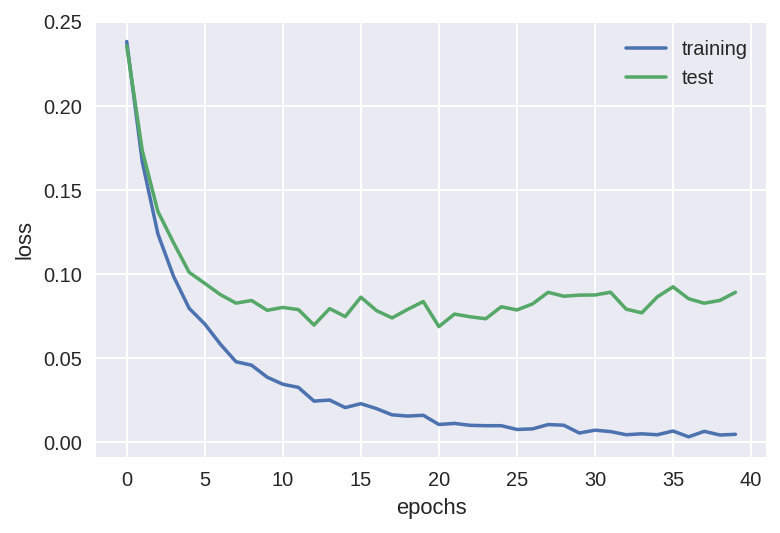

In [59]:
sess = tf.Session()
tf.set_random_seed(2018)
init = tf.global_variables_initializer()
sess.run(init)

eta = 0.001
batch_size = 256
training_epochs = 40
display_step = 2

train_loss = []
test_loss = []
print("Optimization Start")

for epochs in range(training_epochs):
#     ind = np.random.choice(X_train.shape[0], batch_size)
#     sess.run(Optimizer, feed_dict = {X:X_train[ind], Y:y_train[ind],
#                                         keep_prob : 1, learning_rate : eta})
    for i in range(0, X_train.shape[0], batch_size):
        sess.run(Optimizer, feed_dict = {X:X_train[i:i+batch_size], Y:y_train[i:i+batch_size],
                                        keep_prob : 0.8, learning_rate : eta})
        
    train_loss.append(sess.run(cost, feed_dict = {X:X_train, Y:y_train, keep_prob :1}))
    test_loss.append(sess.run(cost, feed_dict = {X:X_test, Y:y_test, keep_prob :1}))
    
    
    if (epochs+1) % display_step == 0 :
        print("{}th epoch, training loss = {:.4f},  test loss = {:.4f}".format(epochs+1, train_loss[-1], test_loss[-1]))
    
plt.plot(range(training_epochs), train_loss)
plt.plot(range(training_epochs), test_loss)
plt.legend(['training', 'test'])                     
plt.xlabel('epochs')    
plt.ylabel('loss')
plt.show()                     

In [60]:
tra_accu = sess.run(accuracy, feed_dict = {X : X_train, Y: y_train, keep_prob :1})
test_accu = sess.run(accuracy, feed_dict = {X : X_test, Y: y_test, keep_prob :1})

print("Train Accuracy : {:.4f}%".format(tra_accu*100) )
print("Test Accuracy : {:.4f}%".format(test_accu*100) )

show_graph(tf.get_default_graph().as_graph_def())


Train Accuracy : 99.8400%
Test Accuracy : 98.3000%
